In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report

import random
import numpy as np
import torch

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If you are using CUDA
torch.backends.cudnn.deterministic = True  # For deterministic results
torch.backends.cudnn.benchmark = False  # For consistency across different environments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_DIR = 'D:\\PAD-UFES\\images'  
METADATA_PATH = 'D:\\PAD-UFES\\metadata.csv'

metadata = pd.read_csv(METADATA_PATH)

def preprocess_metadata(metadata):
    metadata = metadata.fillna('UNK')

    boolean_cols = [
        'smoke',
        'drink',
        'pesticide',
        'skin_cancer_history',
        'cancer_history',
        'has_piped_water',
        'has_sewage_system',
        'itch',
        'grew',
        'hurt',
        'changed',
        'bleed',
        'elevation',
        'biopsed',
    ]
    # Ensure columns are strings and lowercase
    for col in boolean_cols:
        metadata[col] = metadata[col].astype(str).str.lower()
    
    # Map boolean columns to 1/0/-1
    boolean_mapping = {'true': 1, 'false': 0, 'unk': -1}
    for col in boolean_cols:
        metadata[col] = metadata[col].map(boolean_mapping)
    
    # Handle categorical variables
    categorical_cols = [
        'background_father',
        'background_mother',
        'gender',
        'region',
        'diagnostic',
    ]
    # Convert categorical columns to string
    for col in categorical_cols:
        metadata[col] = metadata[col].astype(str)
    
    # One-hot encode categorical variables
    metadata_encoded = pd.get_dummies(metadata[categorical_cols])
    
    # Normalize numerical variables
    numerical_cols = ['age', 'fitspatrick', 'diameter_1', 'diameter_2']
    # Ensure numerical columns are numeric
    for col in numerical_cols:
        metadata[col] = pd.to_numeric(metadata[col], errors='coerce')
    # Fill NaNs in numerical columns with the mean
    metadata[numerical_cols] = metadata[numerical_cols].fillna(metadata[numerical_cols].mean())
    # Scale numerical columns
    scaler = StandardScaler()
    metadata_numeric = metadata[numerical_cols]
    metadata_numeric_scaled = pd.DataFrame(
        scaler.fit_transform(metadata_numeric), columns=numerical_cols
    )
    
    # Combine all metadata features
    metadata_processed = pd.concat(
        [metadata_numeric_scaled.reset_index(drop=True),
         metadata_encoded.reset_index(drop=True),
         metadata[boolean_cols].reset_index(drop=True)], axis=1
    )
    
    return metadata_processed

# Preprocess metadata
metadata_processed = preprocess_metadata(metadata)

def get_image_paths(metadata, image_dir):
    image_paths = []
    for idx, row in metadata.iterrows():
        filename = row['img_id']
        # Ensure filename is a string
        filename = str(filename)
        # Check if filename has an extension
        if not filename.endswith(('.jpg', '.jpeg', '.png')):
            # Try common extensions
            possible_extensions = ['.jpg', '.jpeg', '.png']
            found = False
            for ext in possible_extensions:
                filepath = os.path.join(image_dir, filename + ext)
                if os.path.isfile(filepath):
                    image_paths.append(filepath)
                    found = True
                    break
            if not found:
                print(f"Image file not found for ID: {filename}")
                image_paths.append(None)
        else:
            filepath = os.path.join(image_dir, filename)
            if os.path.isfile(filepath):
                image_paths.append(filepath)
            else:
                print(f"Image file not found: {filepath}")
                image_paths.append(None)
    metadata['ImagePath'] = image_paths
    return metadata

metadata = get_image_paths(metadata, IMAGE_DIR)

# Remove entries with missing images
metadata = metadata[metadata['ImagePath'].notnull()]
metadata_processed = metadata_processed.loc[metadata.index].reset_index(drop=True)
metadata = metadata.reset_index(drop=True)

# Drop diagnostic-related columns from features
diagnostic_cols = ['diagnostic_ACK', 'diagnostic_BCC', 'diagnostic_MEL', 'diagnostic_NEV', 'diagnostic_SCC', 'diagnostic_SEK']
metadata_processed = metadata_processed.drop(columns=diagnostic_cols)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(metadata['diagnostic'])
num_classes = len(label_encoder.classes_)

# Split data into features and labels
X_meta = metadata_processed.reset_index(drop=True)
X_img_paths = metadata['ImagePath'].reset_index(drop=True)
y = pd.Series(y_encoded)

X_train_meta, X_temp_meta, X_train_img_paths, X_temp_img_paths, y_train, y_temp = train_test_split(
    X_meta,
    X_img_paths,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_val_meta, X_test_meta, X_val_img_paths, X_test_img_paths, y_val, y_test = train_test_split(
    X_temp_meta,
    X_temp_img_paths,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Load augmented metadata + image paths
aug_meta_df   = pd.read_csv("D:/PAD-UFES/augmented_metadata.csv")
aug_labels_df = pd.read_csv("D:/PAD-UFES/augmented_labels.csv")

# Combine augmented samples with training set
X_train_meta_final = pd.concat([X_train_meta, aug_meta_df], ignore_index=True)
X_train_img_paths_final = pd.concat([X_train_img_paths.reset_index(drop=True),
                                     aug_labels_df['ImagePath']], ignore_index=True)
y_train_final = pd.concat([y_train.reset_index(drop=True),
                           aug_labels_df['Label']], ignore_index=True)

class PADUFESDataset(Dataset):
    def __init__(self, img_paths, meta_data, labels, transform=None):
        self.img_paths = img_paths.reset_index(drop=True)
        self.meta_data = meta_data.reset_index(drop=True)
        self.labels = pd.Series(labels).reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        meta = torch.tensor(self.meta_data.iloc[idx].values.astype(np.float32))
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return image, meta, label

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(70),          
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = PADUFESDataset(X_train_img_paths_final, X_train_meta_final, y_train_final, transform=train_transform)
val_dataset = PADUFESDataset(X_val_img_paths, X_val_meta, y_val, transform=val_test_transform)
test_dataset = PADUFESDataset(X_test_img_paths, X_test_meta, y_test, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n✅ Loaded Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


✅ Loaded Train: 2966, Val: 230, Test: 230


In [2]:
X_train_meta

,age,fitspatrick,diameter_1,diameter_2,background_father_AUSTRIA,background_father_BRASIL,background_father_BRAZIL,background_father_CZECH,background_father_GERMANY,background_father_ISRAEL,...,cancer_history,has_piped_water,has_sewage_system,itch,grew,hurt,changed,bleed,elevation,biopsed
728,0.474171,-0.452210,-0.272576,2.456416e-01,False,False,False,False,False,False,...,0,1,1,1,1,0,0,1,1,1
1653,-0.469735,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,1,0,0,0,0,0,0
2186,-0.595589,1.249557,-0.416260,-3.963958e-01,False,False,False,False,False,False,...,0,1,1,0,-1,0,-1,0,1,1
127,-1.287787,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,1,0,0,0,1,0,0
903,0.222463,-0.452210,-0.990996,-8.244207e-01,False,False,False,False,True,False,...,0,1,1,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671,0.033682,1.249557,-0.990996,-3.963958e-01,False,False,False,False,False,False,...,1,1,1,1,-1,1,-1,1,1,1
1169,0.348317,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,1,1,0,0,0,0,0
461,0.725880,-0.452210,-0.272576,-1.823833e-01,False,False,False,False,False,False,...,1,1,1,1,-1,1,-1,1,1,1
456,-0.092173,-0.452210,-1.565732,-1.680471e+00,False,False,False,False,True,False,...,1,1,1,1,-1,1,-1,1,0,1


In [3]:
X_val_meta

,age,fitspatrick,diameter_1,diameter_2,background_father_AUSTRIA,background_father_BRASIL,background_father_BRAZIL,background_father_CZECH,background_father_GERMANY,background_father_ISRAEL,...,cancer_history,has_piped_water,has_sewage_system,itch,grew,hurt,changed,bleed,elevation,biopsed
658,0.788807,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,0,0,0,0,0,1,0
1747,0.851734,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,1,0,0,0,0,0,0
922,-0.658516,-0.452210,0.589527,2.456416e-01,False,False,False,False,True,False,...,1,0,0,0,1,0,0,0,1,1
878,-1.161933,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,1,0,0,0,0,0,0
802,-1.791204,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,0.537098,-0.452210,-0.272576,-3.963958e-01,False,False,False,False,True,False,...,0,1,1,1,1,0,0,1,0,1
1110,-0.092173,1.249557,-0.416260,2.456416e-01,False,False,False,False,True,False,...,0,0,0,1,1,0,0,0,0,1
168,0.662952,1.249557,-0.272576,-6.104083e-01,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
1271,1.481005,-0.452210,-0.703628,-6.104083e-01,False,False,False,False,False,False,...,0,0,1,0,0,0,0,0,1,1


In [4]:
X_test_meta

,age,fitspatrick,diameter_1,diameter_2,background_father_AUSTRIA,background_father_BRASIL,background_father_BRAZIL,background_father_CZECH,background_father_GERMANY,background_father_ISRAEL,...,cancer_history,has_piped_water,has_sewage_system,itch,grew,hurt,changed,bleed,elevation,biopsed
1460,0.285390,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,1,0,1,0,0,0,0
1519,1.858567,-2.153977,1.020579,1.315704e+00,False,False,False,False,False,False,...,1,1,1,-1,-1,-1,-1,0,1,1
949,-1.350714,0.000000,0.000000,3.801625e-16,False,False,False,False,False,False,...,-1,-1,-1,0,0,0,1,0,0,0
2063,0.285390,-0.452210,-0.272576,-1.823833e-01,False,False,False,False,False,False,...,0,1,1,1,-1,1,-1,1,1,1
1790,0.725880,-0.452210,0.589527,1.315704e+00,False,False,False,False,False,False,...,1,1,1,1,-1,1,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,-0.532662,-2.153977,0.302159,6.736666e-01,False,False,False,False,True,False,...,1,1,0,1,0,0,0,0,0,1
126,0.096609,-0.452210,-0.128892,-6.104083e-01,False,False,False,False,True,False,...,1,1,1,1,1,0,0,1,1,1
982,1.418078,-0.452210,0.014792,1.315704e+00,False,False,False,False,False,False,...,0,1,1,1,1,0,0,0,0,1
889,0.977588,1.249557,-0.416260,-3.963958e-01,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,1


In [5]:
y_train

728     0
1653    0
2186    1
127     0
903     5
       ..
1671    1
1169    0
461     1
456     1
747     1
Length: 1838, dtype: int32

In [6]:
y_val

658     5
1747    0
922     1
878     0
802     3
       ..
1359    1
1110    4
168     4
1271    4
1949    1
Length: 230, dtype: int32

In [7]:
y_test

1460    0
1519    4
949     0
2063    1
1790    4
       ..
14      1
126     4
982     1
889     4
984     5
Length: 230, dtype: int32

In [9]:
print(num_classes)

6


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


# -------------------------------------------------------------------
#  Cross-Attention Block (image ↔ metadata)
# -------------------------------------------------------------------
class CrossAttention(nn.Module):
    def __init__(self, dim_img, dim_meta, num_heads=4):
        super().__init__()
        
        self.img_proj = nn.Linear(dim_img, dim_img)
        self.meta_proj = nn.Linear(dim_meta, dim_img)

        self.attn = nn.MultiheadAttention(embed_dim=dim_img, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(dim_img)

    def forward(self, img_tokens, meta_tokens):
        """
        img_tokens : [B, N_img, C]
        meta_tokens: [B, N_meta, C]
        """
        # Project metadata to same dimension as image
        meta_tokens = self.meta_proj(meta_tokens)

        # Cross-attention
        fused, _ = self.attn(query=img_tokens, key=meta_tokens, value=meta_tokens)

        # Residual + normalization
        fused = self.norm(img_tokens + fused)

        return fused


# -------------------------------------------------------------------
#     Early Fusion Model with Cross-Attention (Correct Version)
# -------------------------------------------------------------------
class EarlyFusionModel(nn.Module):
    def __init__(self, input_dim_meta, num_classes):
        super().__init__()

        # -----------------------
        # MobileViT backbone
        # -----------------------
        self.mobilevit = timm.create_model(
            "mobilevit_s.cvnets_in1k",
            pretrained=True,
            features_only=True  # <-- get intermediate features
        )
        
        self.out_channels = self.mobilevit.feature_info.channels()  # e.g. [16, 24, 48, 64, 80]

        # We fuse into the **first stage** (true early fusion)
        self.fusion_dim = self.out_channels[0]  

        # -----------------------
        # Metadata embedding
        # -----------------------
        self.meta_embed = nn.Sequential(
            nn.Linear(input_dim_meta, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, self.fusion_dim)  # match image channel dimension
        )

        # Metadata token count
        self.num_meta_tokens = 8
        self.meta_token_expander = nn.Linear(self.fusion_dim, self.num_meta_tokens * self.fusion_dim)

        # -----------------------
        # Cross-Attention Fusion
        # -----------------------
        self.cross_attn = CrossAttention(
            dim_img=self.fusion_dim,
            dim_meta=self.fusion_dim,
            num_heads=4
        )

        # -----------------------
        # Classification head
        # -----------------------
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.out_channels[-1], num_classes)
        )

    def forward(self, img, meta):
        B = img.size(0)

        # ------------------------
        # Step 1 — Extract early image features
        # ------------------------
        feats = self.mobilevit(img)  # list of feature maps
        f1 = feats[0]                # first feature map: [B, C, H, W]

        B, C, H, W = f1.shape

        # Flatten image features into tokens
        img_tokens = f1.flatten(2).transpose(1, 2)  # [B, N_img, C]

        # ------------------------
        # Step 2 — Process metadata → tokens
        # ------------------------
        meta_base = self.meta_embed(meta)  # [B, C]
        meta_tokens = self.meta_token_expander(meta_base)
        meta_tokens = meta_tokens.view(B, self.num_meta_tokens, C)  # [B, N_meta, C]

        # ------------------------
        # Step 3 — Cross-Attention Fusion
        # ------------------------
        fused_tokens = self.cross_attn(img_tokens, meta_tokens)  # [B, N_img, C]

        # Restore feature map shape
        fused_map = fused_tokens.transpose(1, 2).view(B, C, H, W)

        # Replace stage-1 feature map
        feats[0] = fused_map

        # ------------------------
        # Step 4 — Continue MobileViT forward
        # ------------------------
        # manually forward remaining blocks
        x = feats[0]
        for i in range(1, len(feats)):
            x = feats[i]

        # Classifier
        out = self.classifier(x)
        return out


input_dim_meta = 59
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EarlyFusionModel(input_dim_meta, num_classes).to(device)

# Model summary for sanity check
from torchinfo import summary
summary(model=model, 
        input_size=[(16, 3, 224, 224), (16, input_dim_meta)], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
EarlyFusionModel (EarlyFusionModel)                     [16, 3, 224, 224]    [16, 6]              --                   True
├─FeatureListNet (mobilevit)                            [16, 3, 224, 224]    [16, 32, 112, 112]   --                   True
│    └─ConvNormAct (stem)                               [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (conv)                               [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNormAct2d (bn)                         [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    └─Sequential (stages_0)                            [16, 16, 112, 112]   [16, 32, 112, 112]   --                   True
│    │    └─BottleneckBlock (0)                         [16, 16, 112, 112]   [16, 32, 112, 112]   3,968                True
│  

In [13]:
print(input_dim_meta)

59


In [4]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, metas, labels in loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_accuracy_max = -np.inf
        
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_accuracy_max:.6f} --> {val_acc:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_max = val_acc

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, meta, labels in pbar:
        images, meta, labels = images.to(device), meta.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Optional: Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss/len(train_loader), correct/total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, meta, labels in val_loader:
            images, meta, labels = images.to(device), meta.to(device), labels.to(device)
            
            outputs = model(images, meta)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss/len(val_loader), correct/total

def train_model_with_scheduler_and_checkpoint(
    model, train_loader, val_loader, optimizer, criterion, device, 
    epochs=20, patience=5, scheduler_patience=5, checkpoint_dir='checkpoints'):
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, 'mobilevit1.pt')
    
    early_stopping = EarlyStopping(
        patience=patience, 
        verbose=True, 
        path=checkpoint_path
    )
    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='max',  # Changed to max since we're monitoring accuracy
        patience=scheduler_patience, 
        verbose=True,
        factor=0.1,
        min_lr=1e-6
    )
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': []
    }
    
    best_model_epoch = None
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        
        # Training phase
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        
        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Update scheduler based on validation accuracy
        scheduler.step(val_acc)
        
        # Early stopping check
        early_stopping(val_acc, model)
        if val_acc > early_stopping.val_accuracy_max:
            best_model_epoch = epoch + 1
            
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load best model
    model.load_state_dict(torch.load(checkpoint_path))
    
    # Plot training curves
    plot_training_curves_with_checkpoint(history, best_model_epoch)
    
    return model, history

def plot_training_curves_with_checkpoint(history, best_model_epoch):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss curves
    ax1.plot(epochs_range, history['train_loss'], label='Training Loss')
    ax1.plot(epochs_range, history['val_loss'], label='Validation Loss')
    if best_model_epoch:
        ax1.axvline(best_model_epoch, color='r', linestyle='--', label='Best Model')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Accuracy curves
    ax2.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    ax2.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    if best_model_epoch:
        ax2.axvline(best_model_epoch, color='r', linestyle='--', label='Best Model')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    # Learning rate curve
    ax3.plot(epochs_range, history['lr'], label='Learning Rate')
    if best_model_epoch:
        ax3.axvline(best_model_epoch, color='r', linestyle='--', label='Best Model')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()


Training with random seed: 42


c:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.21it/s, loss=0.0353, acc=57.52%]


Train Loss: 1.1248, Train Acc: 0.5752
Val Loss: 1.0934, Val Acc: 0.6130
Validation accuracy increased (-inf --> 0.613043). Saving model...

Epoch 2/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.24it/s, loss=0.0237, acc=72.32%]


Train Loss: 0.7571, Train Acc: 0.7232
Val Loss: 0.8587, Val Acc: 0.6739
Validation accuracy increased (0.613043 --> 0.673913). Saving model...

Epoch 3/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.24it/s, loss=0.0222, acc=73.53%]


Train Loss: 0.7077, Train Acc: 0.7353
Val Loss: 0.8654, Val Acc: 0.6826
Validation accuracy increased (0.673913 --> 0.682609). Saving model...

Epoch 4/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.24it/s, loss=0.0187, acc=77.98%]


Train Loss: 0.5973, Train Acc: 0.7798
Val Loss: 0.8687, Val Acc: 0.6913
Validation accuracy increased (0.682609 --> 0.691304). Saving model...

Epoch 5/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s, loss=0.0173, acc=79.57%]


Train Loss: 0.5516, Train Acc: 0.7957
Val Loss: 0.8622, Val Acc: 0.7174
Validation accuracy increased (0.691304 --> 0.717391). Saving model...

Epoch 6/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s, loss=0.0156, acc=81.59%]


Train Loss: 0.4982, Train Acc: 0.8159
Val Loss: 0.8710, Val Acc: 0.6913
EarlyStopping counter: 1 out of 7

Epoch 7/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0163, acc=80.28%]


Train Loss: 0.5210, Train Acc: 0.8028
Val Loss: 0.8553, Val Acc: 0.7217
Validation accuracy increased (0.717391 --> 0.721739). Saving model...

Epoch 8/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0150, acc=81.49%]


Train Loss: 0.4794, Train Acc: 0.8149
Val Loss: 0.7557, Val Acc: 0.7217
EarlyStopping counter: 1 out of 7

Epoch 9/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0135, acc=84.36%]


Train Loss: 0.4307, Train Acc: 0.8436
Val Loss: 1.0108, Val Acc: 0.7000
EarlyStopping counter: 2 out of 7

Epoch 10/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.26it/s, loss=0.0124, acc=85.33%]


Train Loss: 0.3942, Train Acc: 0.8533
Val Loss: 1.1578, Val Acc: 0.6478
EarlyStopping counter: 3 out of 7

Epoch 11/100


Training: 100%|██████████| 93/93 [01:15<00:00,  1.23it/s, loss=0.0119, acc=85.84%]


Train Loss: 0.3796, Train Acc: 0.8584
Val Loss: 0.8759, Val Acc: 0.7087
EarlyStopping counter: 4 out of 7

Epoch 12/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s, loss=0.0076, acc=90.86%]


Train Loss: 0.2435, Train Acc: 0.9086
Val Loss: 0.6345, Val Acc: 0.7696
Validation accuracy increased (0.721739 --> 0.769565). Saving model...

Epoch 13/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s, loss=0.0058, acc=93.39%]


Train Loss: 0.1843, Train Acc: 0.9339
Val Loss: 0.7590, Val Acc: 0.7609
EarlyStopping counter: 1 out of 7

Epoch 14/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.26it/s, loss=0.0051, acc=94.17%]


Train Loss: 0.1622, Train Acc: 0.9417
Val Loss: 0.7841, Val Acc: 0.7522
EarlyStopping counter: 2 out of 7

Epoch 15/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s, loss=0.0044, acc=95.01%]


Train Loss: 0.1409, Train Acc: 0.9501
Val Loss: 0.8884, Val Acc: 0.7739
Validation accuracy increased (0.769565 --> 0.773913). Saving model...

Epoch 16/100


Training: 100%|██████████| 93/93 [01:15<00:00,  1.24it/s, loss=0.0040, acc=95.52%]


Train Loss: 0.1268, Train Acc: 0.9552
Val Loss: 0.8620, Val Acc: 0.7565
EarlyStopping counter: 1 out of 7

Epoch 17/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.21it/s, loss=0.0037, acc=95.68%]


Train Loss: 0.1171, Train Acc: 0.9568
Val Loss: 0.8884, Val Acc: 0.7913
Validation accuracy increased (0.773913 --> 0.791304). Saving model...

Epoch 18/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0032, acc=96.36%]


Train Loss: 0.1029, Train Acc: 0.9636
Val Loss: 0.9540, Val Acc: 0.7739
EarlyStopping counter: 1 out of 7

Epoch 19/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0032, acc=96.36%]


Train Loss: 0.1027, Train Acc: 0.9636
Val Loss: 0.9893, Val Acc: 0.7522
EarlyStopping counter: 2 out of 7

Epoch 20/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0029, acc=96.97%]


Train Loss: 0.0910, Train Acc: 0.9697
Val Loss: 0.9320, Val Acc: 0.7652
EarlyStopping counter: 3 out of 7

Epoch 21/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0027, acc=96.76%]


Train Loss: 0.0846, Train Acc: 0.9676
Val Loss: 0.9092, Val Acc: 0.7783
EarlyStopping counter: 4 out of 7

Epoch 22/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0024, acc=97.30%]


Train Loss: 0.0779, Train Acc: 0.9730
Val Loss: 0.9963, Val Acc: 0.7739
EarlyStopping counter: 5 out of 7

Epoch 23/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0022, acc=97.34%]


Train Loss: 0.0695, Train Acc: 0.9734
Val Loss: 0.9901, Val Acc: 0.7913
EarlyStopping counter: 6 out of 7

Epoch 24/100


Training: 100%|██████████| 93/93 [01:15<00:00,  1.23it/s, loss=0.0022, acc=97.74%]


Train Loss: 0.0696, Train Acc: 0.9774
Val Loss: 0.9491, Val Acc: 0.7913
EarlyStopping counter: 7 out of 7
Early stopping triggered


C:\Users\User\AppData\Local\Temp\ipykernel_9312\877401473.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


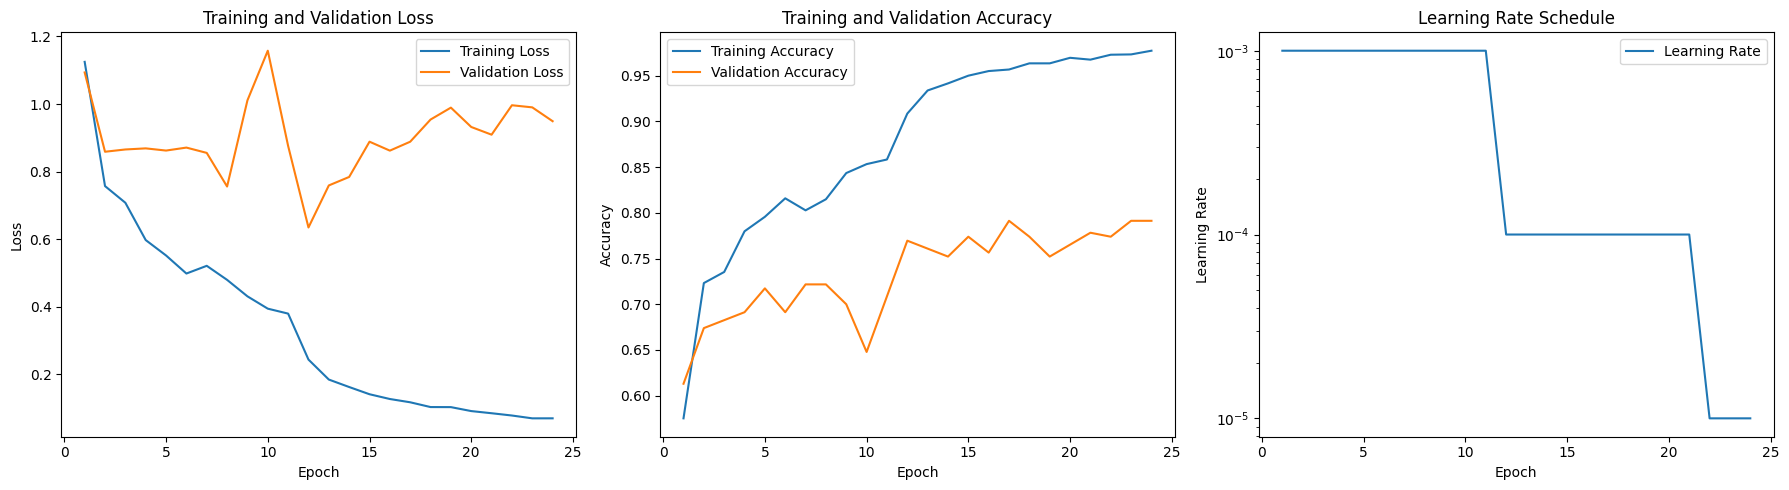

Seed 42: Accuracy=0.8043, Precision=0.8279, Recall=0.8404, F1 Score=0.8339

Training with random seed: 123


c:\Users\User\anaconda3\envs\torch\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.22it/s, loss=0.0348, acc=59.64%]


Train Loss: 1.1093, Train Acc: 0.5964
Val Loss: 1.0450, Val Acc: 0.5826
Validation accuracy increased (-inf --> 0.582609). Saving model...

Epoch 2/100


Training: 100%|██████████| 93/93 [01:17<00:00,  1.19it/s, loss=0.0249, acc=70.13%]


Train Loss: 0.7933, Train Acc: 0.7013
Val Loss: 0.9553, Val Acc: 0.6957
Validation accuracy increased (0.582609 --> 0.695652). Saving model...

Epoch 3/100


Training: 100%|██████████| 93/93 [01:18<00:00,  1.18it/s, loss=0.0219, acc=74.75%]


Train Loss: 0.6979, Train Acc: 0.7475
Val Loss: 0.9188, Val Acc: 0.6739
EarlyStopping counter: 1 out of 7

Epoch 4/100


Training: 100%|██████████| 93/93 [01:17<00:00,  1.20it/s, loss=0.0195, acc=76.60%]


Train Loss: 0.6208, Train Acc: 0.7660
Val Loss: 0.7198, Val Acc: 0.7217
Validation accuracy increased (0.695652 --> 0.721739). Saving model...

Epoch 5/100


Training: 100%|██████████| 93/93 [01:17<00:00,  1.20it/s, loss=0.0175, acc=79.27%]


Train Loss: 0.5579, Train Acc: 0.7927
Val Loss: 0.8433, Val Acc: 0.7174
EarlyStopping counter: 1 out of 7

Epoch 6/100


Training: 100%|██████████| 93/93 [01:17<00:00,  1.19it/s, loss=0.0161, acc=81.12%]


Train Loss: 0.5147, Train Acc: 0.8112
Val Loss: 0.9040, Val Acc: 0.6913
EarlyStopping counter: 2 out of 7

Epoch 7/100


Training: 100%|██████████| 93/93 [01:22<00:00,  1.13it/s, loss=0.0153, acc=82.23%]


Train Loss: 0.4891, Train Acc: 0.8223
Val Loss: 0.9918, Val Acc: 0.6957
EarlyStopping counter: 3 out of 7

Epoch 8/100


Training: 100%|██████████| 93/93 [01:20<00:00,  1.15it/s, loss=0.0143, acc=83.31%]


Train Loss: 0.4552, Train Acc: 0.8331
Val Loss: 0.8818, Val Acc: 0.6913
EarlyStopping counter: 4 out of 7

Epoch 9/100


Training: 100%|██████████| 93/93 [01:20<00:00,  1.15it/s, loss=0.0109, acc=87.59%]


Train Loss: 0.3490, Train Acc: 0.8759
Val Loss: 0.6875, Val Acc: 0.7609
Validation accuracy increased (0.721739 --> 0.760870). Saving model...

Epoch 10/100


Training: 100%|██████████| 93/93 [01:14<00:00,  1.24it/s, loss=0.0080, acc=91.30%]


Train Loss: 0.2566, Train Acc: 0.9130
Val Loss: 0.7865, Val Acc: 0.7478
EarlyStopping counter: 1 out of 7

Epoch 11/100


Training: 100%|██████████| 93/93 [01:15<00:00,  1.24it/s, loss=0.0074, acc=91.44%]


Train Loss: 0.2367, Train Acc: 0.9144
Val Loss: 0.7080, Val Acc: 0.7609
EarlyStopping counter: 2 out of 7

Epoch 12/100


Training: 100%|██████████| 93/93 [01:15<00:00,  1.23it/s, loss=0.0066, acc=92.11%]


Train Loss: 0.2092, Train Acc: 0.9211
Val Loss: 0.7962, Val Acc: 0.7565
EarlyStopping counter: 3 out of 7

Epoch 13/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0060, acc=92.92%]


Train Loss: 0.1926, Train Acc: 0.9292
Val Loss: 0.7955, Val Acc: 0.7652
Validation accuracy increased (0.760870 --> 0.765217). Saving model...

Epoch 14/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0051, acc=93.86%]


Train Loss: 0.1635, Train Acc: 0.9386
Val Loss: 0.8769, Val Acc: 0.7522
EarlyStopping counter: 1 out of 7

Epoch 15/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0056, acc=93.90%]


Train Loss: 0.1775, Train Acc: 0.9390
Val Loss: 0.8346, Val Acc: 0.7609
EarlyStopping counter: 2 out of 7

Epoch 16/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0048, acc=94.61%]


Train Loss: 0.1529, Train Acc: 0.9461
Val Loss: 0.8403, Val Acc: 0.7565
EarlyStopping counter: 3 out of 7

Epoch 17/100


Training: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s, loss=0.0047, acc=94.40%]


Train Loss: 0.1499, Train Acc: 0.9440
Val Loss: 0.9326, Val Acc: 0.7565
EarlyStopping counter: 4 out of 7

Epoch 18/100


Training: 100%|██████████| 93/93 [01:16<00:00,  1.21it/s, loss=0.0043, acc=95.31%]


Train Loss: 0.1356, Train Acc: 0.9531
Val Loss: 0.8924, Val Acc: 0.7478
EarlyStopping counter: 5 out of 7

Epoch 19/100


Training: 100%|██████████| 93/93 [01:18<00:00,  1.19it/s, loss=0.0042, acc=95.48%]


Train Loss: 0.1337, Train Acc: 0.9548
Val Loss: 0.8905, Val Acc: 0.7565
EarlyStopping counter: 6 out of 7

Epoch 20/100


Training: 100%|██████████| 93/93 [01:17<00:00,  1.19it/s, loss=0.0035, acc=96.26%]


Train Loss: 0.1115, Train Acc: 0.9626
Val Loss: 0.8898, Val Acc: 0.7565
EarlyStopping counter: 7 out of 7
Early stopping triggered


C:\Users\User\AppData\Local\Temp\ipykernel_9312\877401473.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


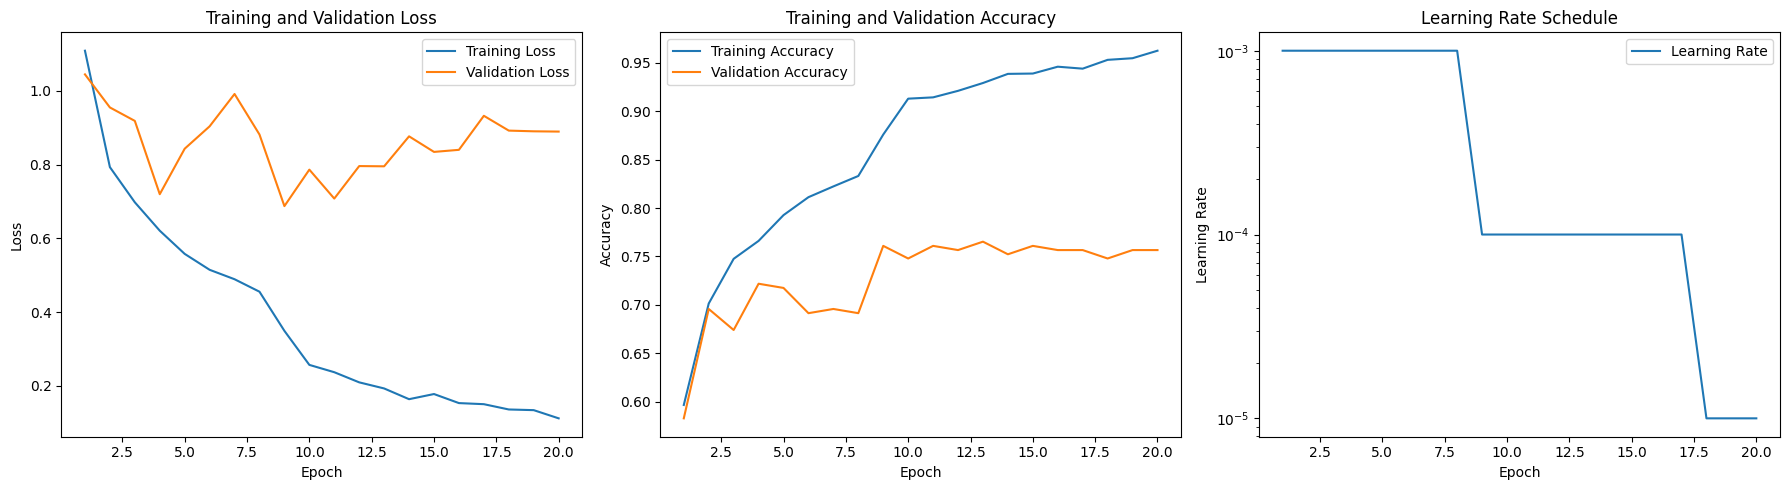

Seed 123: Accuracy=0.7783, Precision=0.8184, Recall=0.8063, F1 Score=0.8083
Accuracy: Mean=0.7913, StdDev=0.0130
Precision: Mean=0.8231, StdDev=0.0047
Recall: Mean=0.8233, StdDev=0.0171
F1_score: Mean=0.8211, StdDev=0.0128
Best model achieved an accuracy of 0.8043
Best model loaded successfully!


C:\Users\User\AppData\Local\Temp\ipykernel_9312\2419267514.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:\\PAD-UFES\\best_early_fu

In [ ]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Function to evaluate test metrics
def evaluate_test_metrics(model, test_loader, device):
    true_labels, pred_labels = test(model, test_loader, device)
    acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    return acc, precision, recall, f1

# Placeholder for results
results = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": []
}

best_accuracy = 0.0
best_model_state = None

# Run experiment for 3 random seeds
seeds = [42, 123, 569]  # Example random seeds
for seed in seeds:
    print(f"\nTraining with random seed: {seed}")
    set_random_seed(seed)
    
    # Reinitialize model, optimizer, and criterion
    model = EarlyFusionModel(input_dim_meta, num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    model, history = train_model_with_scheduler_and_checkpoint(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        epochs=100,
        patience=7,
        scheduler_patience=3,
        checkpoint_dir='D:\\PAD-UFES\\checkpoints'
    )
    
    # Evaluate on test set
    acc, precision, recall, f1 = evaluate_test_metrics(model, test_loader, device)
    print(f"Seed {seed}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")
    
    # Save metrics
    results["accuracy"].append(acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["f1_score"].append(f1)
    
    # Update the best model
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_state = model.state_dict()

# Compute average and standard deviation
metrics_summary = {}
for metric, values in results.items():
    avg = np.mean(values)
    std_dev = np.std(values)
    metrics_summary[metric] = (avg, std_dev)
    print(f"{metric.capitalize()}: Mean={avg:.4f}, StdDev={std_dev:.4f}")

# Save the best model
print(f"Best model achieved an accuracy of {best_accuracy:.4f}")
torch.save(best_model_state, 'D:\\PAD-UFES\\best_early_fusion_CrossattentionmobilevitDA.pth')

model = EarlyFusionModel(input_dim_meta, num_classes).to(device)
model.load_state_dict(torch.load('D:\\PAD-UFES\\best_early_fusion_CrossattentionmobilevitDA.pth'))
model.eval()
print("Best model loaded successfully!")

In [10]:
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def test(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, metas, labels in loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

true_labels, pred_labels = test(model, test_loader, device)

class_names = label_encoder.classes_
report = classification_report(true_labels, pred_labels, digits=4,target_names=class_names)
print("Classification Report:")
print(report)
cm = confusion_matrix(true_labels, pred_labels)

Classification Report:
              precision    recall  f1-score   support

         ACK     0.8056    0.7945    0.8000        73
         BCC     0.7952    0.7765    0.7857        85
         MEL     1.0000    1.0000    1.0000         5
         NEV     0.9200    0.9583    0.9388        24
         SCC     0.5714    0.6000    0.5854        20
         SEK     0.8750    0.9130    0.8936        23

    accuracy                         0.8043       230
   macro avg     0.8279    0.8404    0.8339       230
weighted avg     0.8045    0.8043    0.8042       230



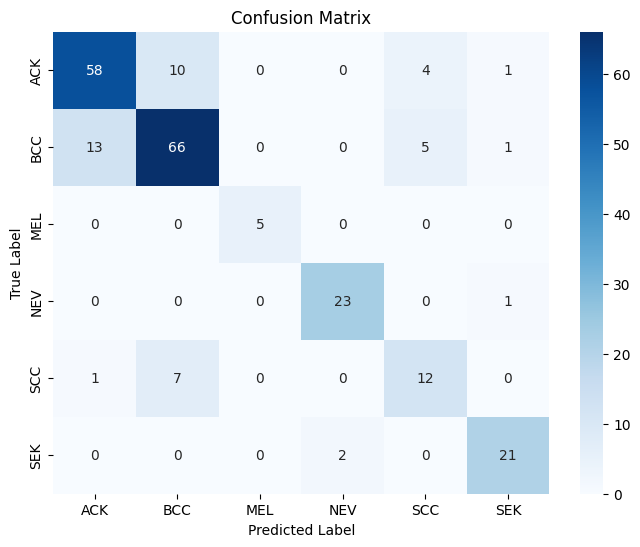

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".0f", xticklabels = class_names, yticklabels = class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

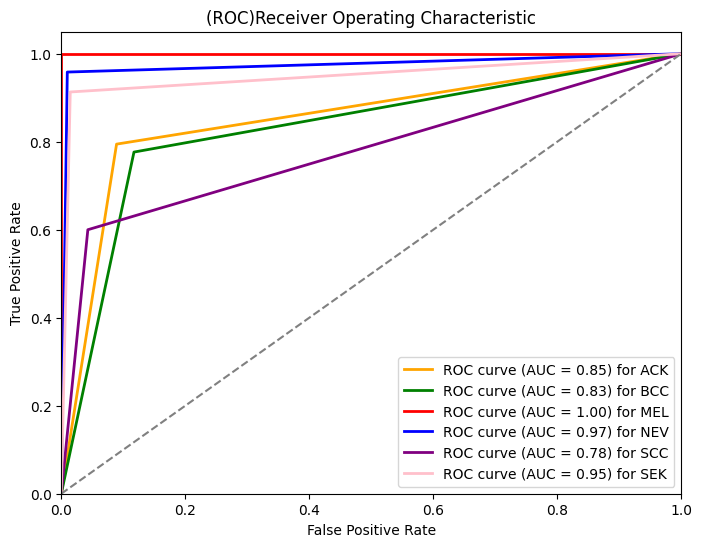

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
fpr = dict()
tpr = dict()
roc_auc = dict()

n_class = 6

for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, np.array(pred_labels) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['orange', 'green', 'red', 'blue', 'purple', 'pink']

for i in range(n_class):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC)Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [13]:
import torch
import torch.nn as nn
import time
import numpy as np
from thop import profile   # <-- THOP works for transformer models


meta_dim = 59
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# --------------------------------------------------
# Count Trainable Parameters
# --------------------------------------------------
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_m = count_parameters(model) / 1e6
print(f"Total Trainable Parameters: {params_m:.3f} M")



# --------------------------------------------------
# FLOPs (THOP supports multi-input models)
# --------------------------------------------------
dummy_img = torch.randn(1, 3, 224, 224).to(device)
dummy_meta = torch.randn(1, meta_dim).to(device)

model.eval()
model.to(device)

with torch.no_grad():
    flops, params = profile(model, inputs=(dummy_img, dummy_meta))

flops_g = flops / 1e9
print(f"FLOPs: {flops_g:.3f} GFLOPs")



# --------------------------------------------------
# GPU Latency
# --------------------------------------------------
def measure_gpu_latency(model, device, meta_dim=59, runs=200, warmup=30):
    if not torch.cuda.is_available():
        print("CUDA not available — skipping GPU latency.")
        return None, None, None

    model.eval()
    model.to(device)

    dummy_img = torch.randn(1, 3, 224, 224, device=device)
    dummy_meta = torch.randn(1, meta_dim, device=device)

    # Warmup
    for _ in range(warmup):
        _ = model(dummy_img, dummy_meta)
    torch.cuda.synchronize()

    times = []
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    for _ in range(runs):
        start_event.record()
        _ = model(dummy_img, dummy_meta)
        end_event.record()
        torch.cuda.synchronize()
        times.append(start_event.elapsed_time(end_event))

    times = np.array(times)
    mean = times.mean()
    std = times.std()
    fps = 1000.0 / mean
    return mean, std, fps


gpu_mean, gpu_std, gpu_fps = measure_gpu_latency(model, device, meta_dim)

if gpu_mean is not None:
    print(f"GPU Latency: {gpu_mean:.3f} ± {gpu_std:.3f} ms")
    print(f"GPU FPS: {gpu_fps:.2f}")
else:
    print("GPU latency not computed.")



# --------------------------------------------------
# CPU Latency
# --------------------------------------------------
def measure_cpu_latency(model, meta_dim=59, runs=100, warmup=20):
    model_cpu = model.cpu()
    model_cpu.eval()

    dummy_img = torch.randn(1, 3, 224, 224)
    dummy_meta = torch.randn(1, meta_dim)

    for _ in range(warmup):
        _ = model_cpu(dummy_img, dummy_meta)

    times = []
    for _ in range(runs):
        start = time.perf_counter()
        _ = model_cpu(dummy_img, dummy_meta)
        end = time.perf_counter()
        times.append((end - start) * 1000.0)  # ms

    times = np.array(times)
    mean = times.mean()
    std = times.std()
    fps = 1000.0 / mean
    return mean, std, fps


cpu_mean, cpu_std, cpu_fps = measure_cpu_latency(model, meta_dim)
print(f"CPU Latency: {cpu_mean:.3f} ± {cpu_std:.3f} ms")
print(f"CPU FPS: {cpu_fps:.2f}")



# --------------------------------------------------
# Final Stats Dictionary
# --------------------------------------------------
efficiency_stats = {
    "params_M": params_m,
    "flops_G": flops_g,
    "gpu_latency_ms_mean": gpu_mean,
    "gpu_latency_ms_std": gpu_std,
    "gpu_fps": gpu_fps,
    "cpu_latency_ms_mean": cpu_mean,
    "cpu_latency_ms_std": cpu_std,
    "cpu_fps": cpu_fps,
}

print("\n=== Final Efficiency Stats (Copy to Paper Table) ===")
for k, v in efficiency_stats.items():
    print(f"{k}: {v}")


Total Trainable Parameters: 4.968 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
FLOPs: 1.422 GFLOPs
GPU Latency: 9.604 ± 1.001 ms
GPU FPS: 104.12
CPU Latency: 40.003 ± 3.376 ms
CPU FPS: 25.00

=== Final Efficiency Stats (Copy to Paper Table) ===
params_M: 4.968134
flops_G: 1.421842816
gpu_latency_ms_mean: 9.603904633522033
gpu_latency_ms_std: 1.0011091083504138
gpu_fps: 104.12431590683869
cpu_latency_ms_mean: 40.003352004569024
cpu_latency_ms_std: 3.376454023983597
cpu